# Archivos de fechas y geojson

## Descarga de archivo json

In [400]:
import json
import urllib.request, urllib.parse, urllib.error
import ssl

ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

url="https://bitbucket.org/adoval4/space-ag-data-analyst-challenge/raw/37385be5a0c78d3b98b64ccc99e6172d36ad68ea/farm_map.json"

uh = urllib.request.urlopen(url, context=ctx)
data = uh.read().decode()

gjson = json.loads(data)


## Archivo de fechas

In [141]:
import pandas as pd
df_fechas=pd.read_excel("../data/SentinelHubImage-available_dates.xlsx")
df_fechas

,id,farm,_date,_datetime_utc,validated
0,14180,163,2020-04-20,2020-04-20 15:26:52,1
1,13892,163,2020-04-15,2020-04-15 15:26:57,1
2,11899,163,2020-03-11,2020-03-11 15:26:55,1
3,11202,163,2020-02-15,2020-02-15 15:26:51,1
4,10946,163,2020-02-10,2020-02-10 15:26:52,1
...,...,...,...,...,...
84,8513,163,2016-12-22,2016-12-22 15:23:53,1
85,8514,163,2016-12-02,2016-12-02 15:21:03,1
86,8515,163,2016-11-22,2016-11-22 15:19:30,1
87,8518,163,2016-09-13,2016-09-13 15:26:48,1


In [142]:
print("Validamos que en los campos farm y validated solo hay un valor")
print(df_fechas.farm.unique())
print(df_fechas.validated.unique())

Validamos que en los campos farm y validated solo hay un valor
[163]
[1]


In [143]:
print("Sacamos los campos farm y validated de fechas")
df_fechas.drop(columns=["farm","validated"],inplace=True)
df_fechas.head()

Sacamos los campos farm y validated de fechas


,id,_date,_datetime_utc
0,14180,2020-04-20,2020-04-20 15:26:52
1,13892,2020-04-15,2020-04-15 15:26:57
2,11899,2020-03-11,2020-03-11 15:26:55
3,11202,2020-02-15,2020-02-15 15:26:51
4,10946,2020-02-10,2020-02-10 15:26:52


### Creamos un diccionario con el id y el bounding box

In [375]:
lotes_fechas={}
for lote in gjson["features"][:]:
    id_=lote["properties"]["unit"]["id"]
    cord=lote["geometry"]["coordinates"][0]
    valor=gjson["features"][0]["properties"]["values"][0]["value"]
    long_cord=[x[0] for x in cord]
    lat_cord=[x[1] for x in cord]
    bbox=[min(long_cord),min(lat_cord),max(long_cord),max(lat_cord)]
    fechas=df_fechas._date.tolist()
    lotes_fechas[id_]={"bbox":bbox,"fechas":fechas,"valor":valor}


Notamos que el valor de cada lote es único

# Sentinelhub data
Sentinelhub set up

In [26]:
from sentinelhub import SHConfig
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox

%reload_ext autoreload
%autoreload 2
%matplotlib inline


INSTANCE_ID = "quita la mia por privacidad"  

if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None
    

def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

## Hacemos un request de las y las guardamos en el directorio imágenes

Este paso es necesario solo si no estan guardada las bandas

In [236]:
for id_ in lotes_fechas.keys():
    for fecha in lotes_fechas[id_]["fechas"]:
        
        bbox_coords_wgs84=lotes_fechas[id_]["bbox"]
        bbox = BBox(bbox=bbox_coords_wgs84, crs=CRS.WGS84)
        
        wms_bands_request = WmsRequest(
        data_folder='../data/imagenes',
        layer='BANDS-S2-L1C',
        bbox=bbox,
        time=fecha,
        width=512,
        height=512,
        image_format=MimeType.TIFF_d32f,
        config=config
        )
        try:
            wms_bands_img = wms_bands_request.get_data()
            wms_bands_request.save_data()
        except:
            continue


# Leemos las bandas y calculamos el NDVI + Estadísticas descriptivas

In [ ]:
results_img=[]

for id_ in list(lotes_fechas.keys()):
    for fecha in lotes_fechas[id_]["fechas"]:

        bbox_coords_wgs84=lotes_fechas[id_]["bbox"]
        bbox = BBox(bbox=bbox_coords_wgs84, crs=CRS.WGS84)
        
        wms_bands_request = WmsRequest(
        data_folder='../data/imagenes',
        layer='BANDS-S2-L1C',
        bbox=bbox,
        time=fecha,
        width=512,
        height=512,
        image_format=MimeType.TIFF_d32f,
        config=config)
        
        wms_bands_img = wms_bands_request.get_data()
        ndvi=(wms_bands_img[-1][:, :, 7]-wms_bands_img[-1][:, :, 3])/(wms_bands_img[-1][:, :, 3]+wms_bands_img[-1][:, :, 7])
        results_img.append({"id":id_,"fecha":fecha,"ndvi":ndvi})  
 

Para facilitar el cálculo y la presentación de resultados, pasamos los resultados de cada imagen (numpy matrix) a un data frame junto con el id del lote respectivo y la fecha

In [407]:
df_nvdi=pd.DataFrame(results_img)

Calculamos la media del nvdi de cada imagen y la desviacion estándar de cada imagen. 

In [379]:
df_nvdi["ndvi_mean"]=df_nvdi.ndvi.apply(lambda x: x.mean())
df_nvdi["ndvi_std_im"]=df_nvdi.ndvi.apply(lambda x: x.std())
df_nvdi.fecha=pd.to_datetime(df_nvdi.fecha)


Todas las imagenes tiene un NDVI positivo

In [406]:
df_nvdi[df_nvdi["ndvi_mean"]>=0].shape[0]

2937

# Insights

Para tener una visión global del comportamiento de los lotes calcularemos la media del nvdi promedio de cada imagen en el tiempo, la media de las desviaciones estandar en el tiempo, y la desviación estandar de la media.

In [353]:
df_plot_mean=df_nvdi.groupby("id").agg({"ndvi_mean":"mean","ndvi_std_im":"mean"}).reset_index()
df_plot_std=df_nvdi.groupby("id").agg({"ndvi_mean":"std"}).rename(columns={"ndvi_mean":"ndvi_std_temp"}).reset_index()
df_plot=pd.merge(df_plot_mean,df_plot_std,on="id")
df_plot.head()

,id,ndvi_mean,ndvi_std_im,ndvi_std_temp
0,90214,0.499089,0.142895,0.043535
1,90215,0.493178,0.148106,0.044657
2,90216,0.546127,0.121247,0.048594
3,90217,0.544816,0.116854,0.048866
4,90218,0.551347,0.125482,0.046914


Utilizando la media en el tiempo (ndvi_mean), la media de las desviaciones estandar en el tiempo(ndvi_std) y la desviación estándar de la media en el tiempo (ndvi_std_temp), en los siguiente plots podemos identificar dos grupos y tendencias en sus comportamientos:

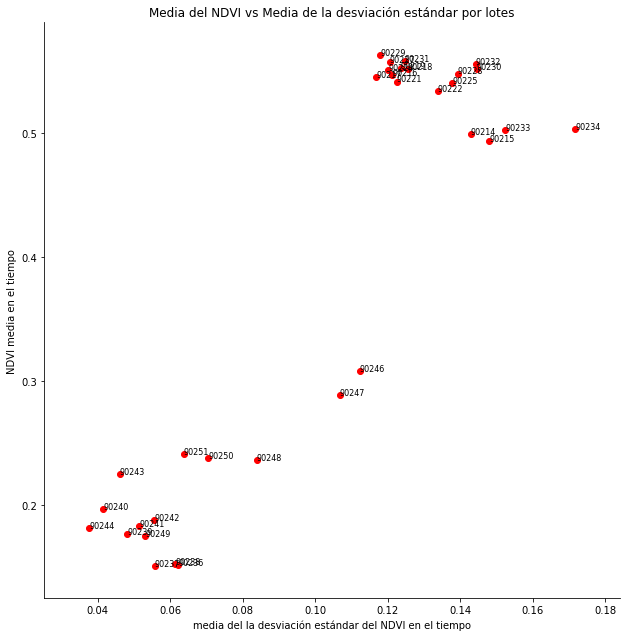

In [355]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(8,8))
ax=fig.add_axes([0,0,1,1])
ax.scatter(df_plot.ndvi_std_im, df_plot.ndvi_mean, color="red",label="lotes")
ax.set_xlabel('media del la desviación estándar del NDVI en el tiempo')
ax.set_ylabel('NDVI media en el tiempo')
ax.set_title('Media del NDVI vs Media de la desviación estándar por lotes')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for label, x, y in zip(df_plot.id.astype(str), df_plot.ndvi_std_im, df_plot.ndvi_mean):
    plt.annotate(
        label,
        xy=(x, y), size=8)

plt.show()


Podemos ver la existencia de 2 clusters:

1.-  Los que tiene un NDVI promedio mayor que 4.5

2.-  Los que tiene un NDVI promedio menor que 3.5

Los del primer grupo tienen un promedio de la desviación estándar de las imagenes mayor que  las del grupo 2. Podemos interpretar de esto que los lotes con menor NDVI son más homogeneos que los lotes del grupo 1 y que este comportamiento se mantiene en el tiempo.

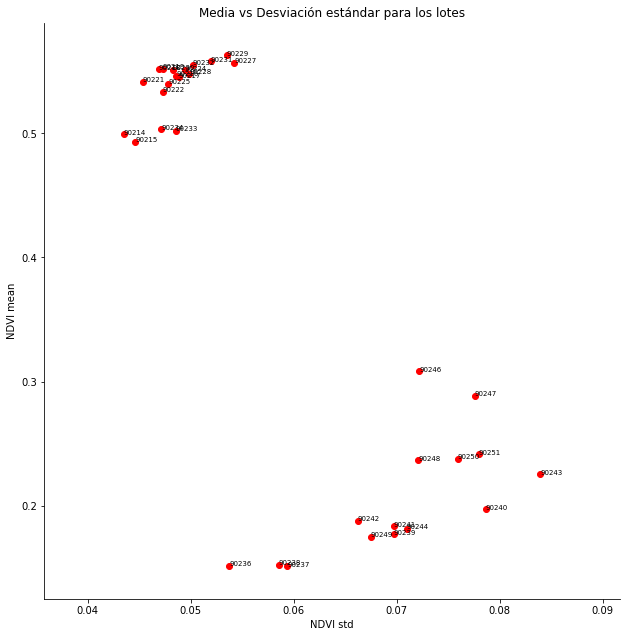

In [329]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_axes([0,0,1,1])
ax.scatter(df_plot.ndvi_std_temp, df_plot.ndvi_mean, color="red",label="lotes")
ax.set_xlabel('NDVI std')
ax.set_ylabel('NDVI mean')
ax.set_title('Media vs Desviación estándar para los lotes')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for label, x, y in zip(df_plot.id.astype(str), df_plot.ndvi_std_temp,df_plot.ndvi_mean ):
    plt.annotate(
        label,
        xy=(x, y), size=7)

plt.show()



Al igual que en el cálculo anterior, vemos la existencia 2 clusters
(uno con NDVI promedio mayor que 4.5 y otro con NDVI promedio menor que 3.5)
 
Para el primer grupo, la desviación estándar en tiempo del NDVI es menor que para las del 
del segundo grupo. Podemos interpretar esto que los lotes cambian en el tiempo más que los del grupo 1.

El gráfico anterior tambien se puede representar en un boxplot como el siguiente:

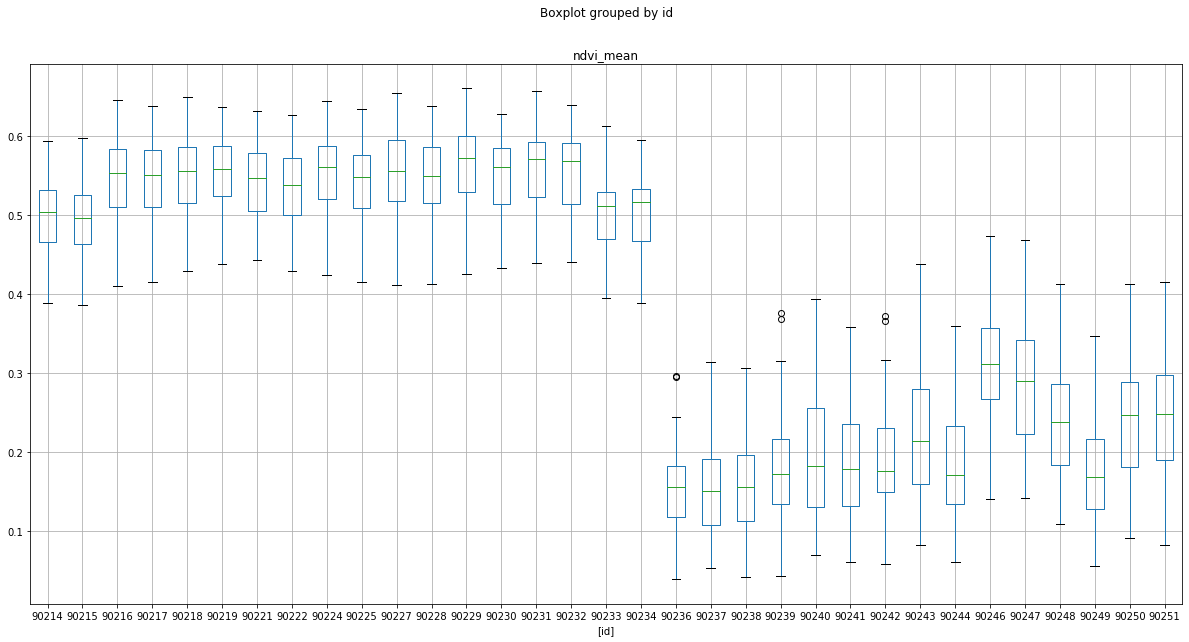

In [311]:
df_nvdi.boxplot(by=['id'],column=["ndvi_mean"], figsize=(20,10))

## Series de tiempo para los lotes

Analizaremos las series de tiempo de cada uno de estos grupos por separado

In [345]:
lotes_ndvi_altos=df_plot[df_plot.ndvi_mean>=0.35].id.tolist()
lotes_ndvi_bajos=df_plot[df_plot.ndvi_mean<0.35].id.tolist()

### Lotes con mayor NDVI promedio-Primer grupo

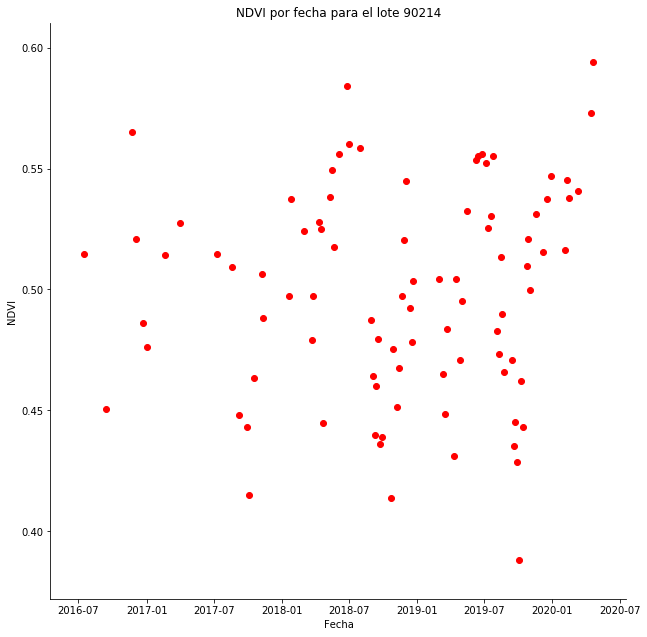

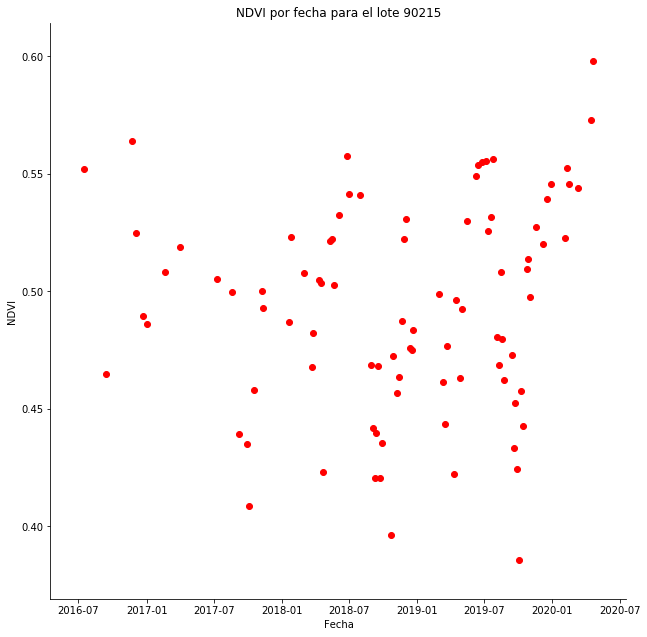

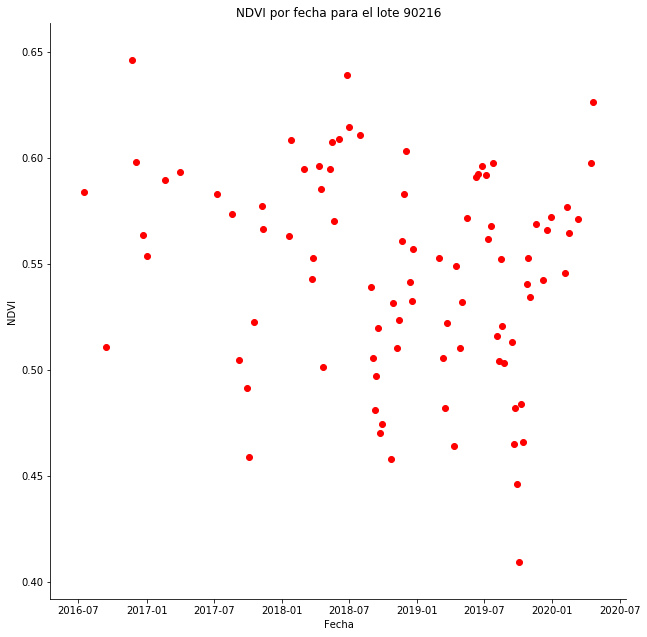

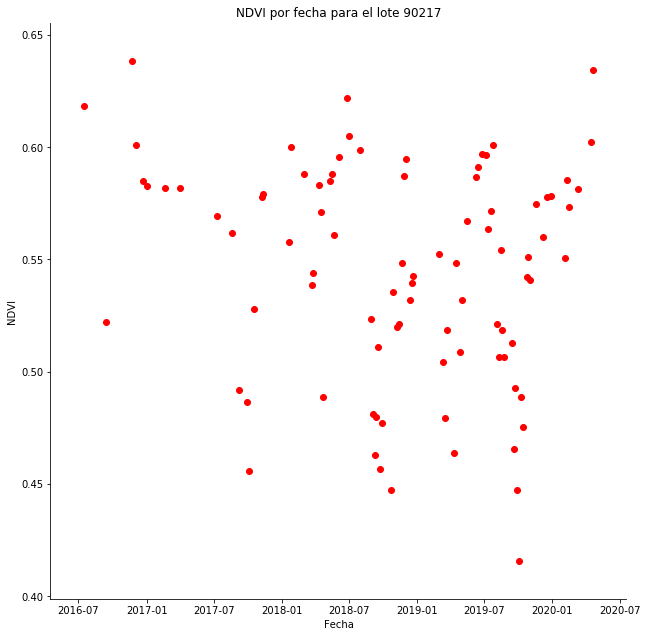

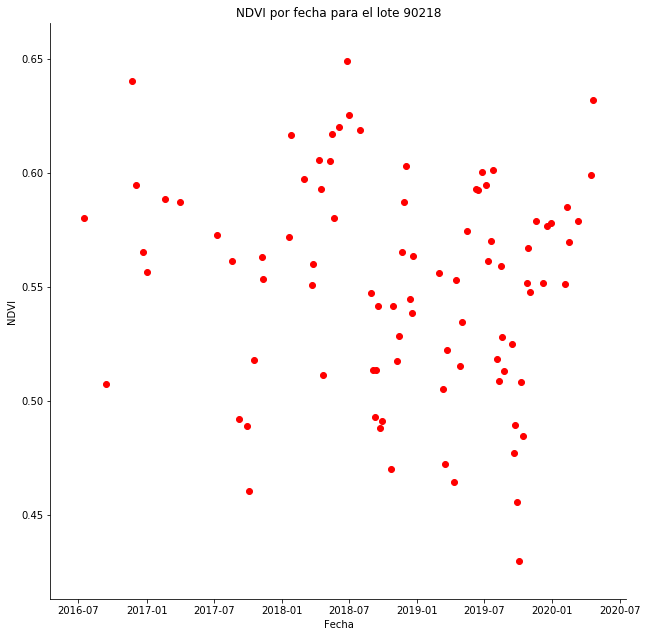

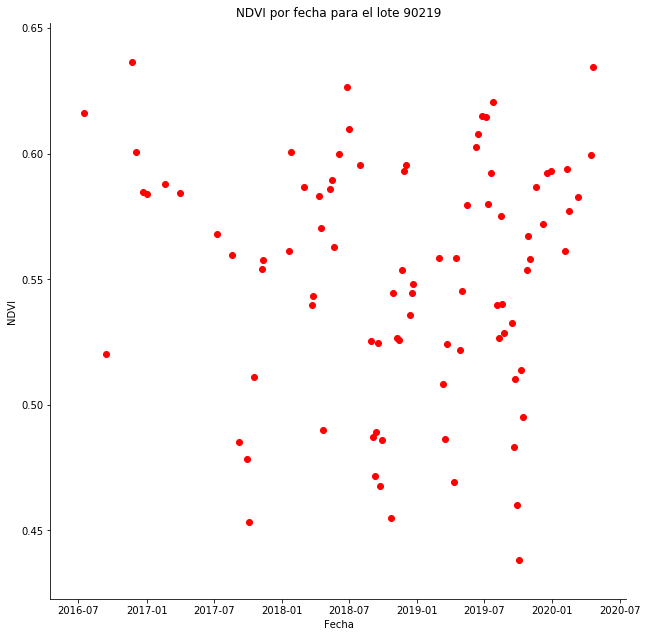

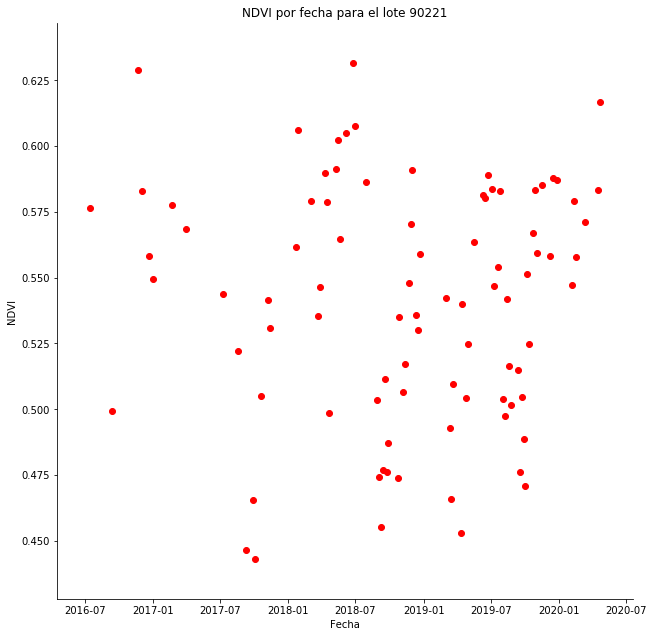

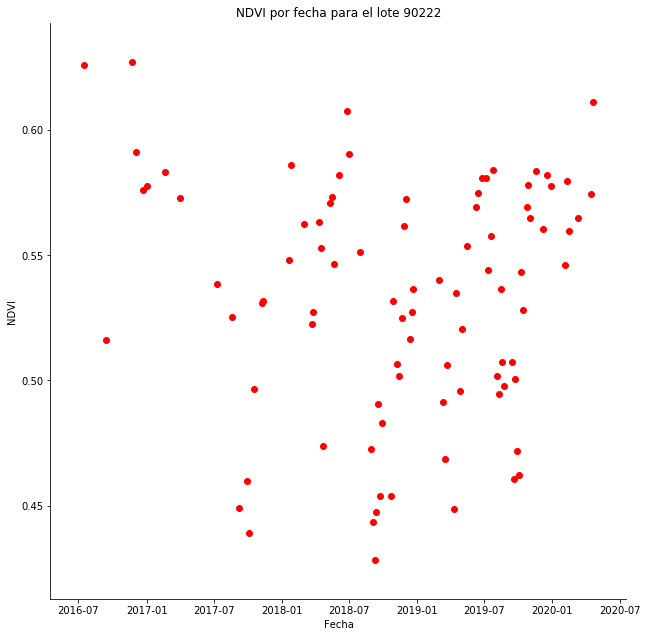

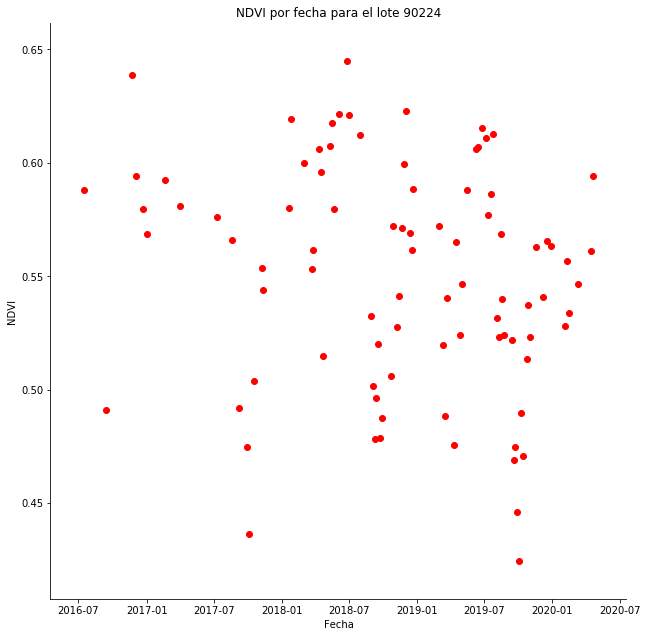

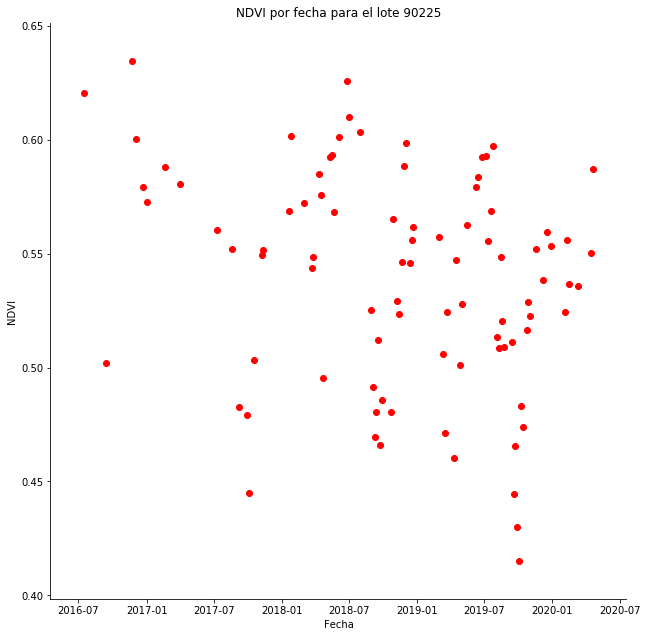

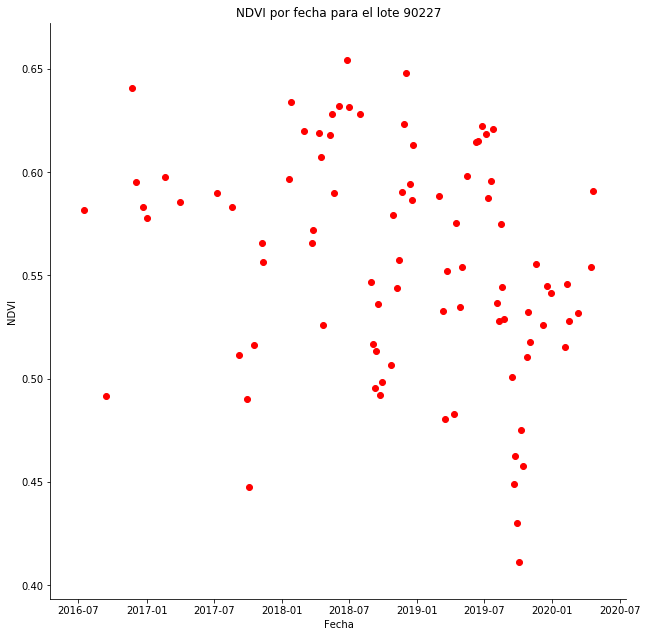

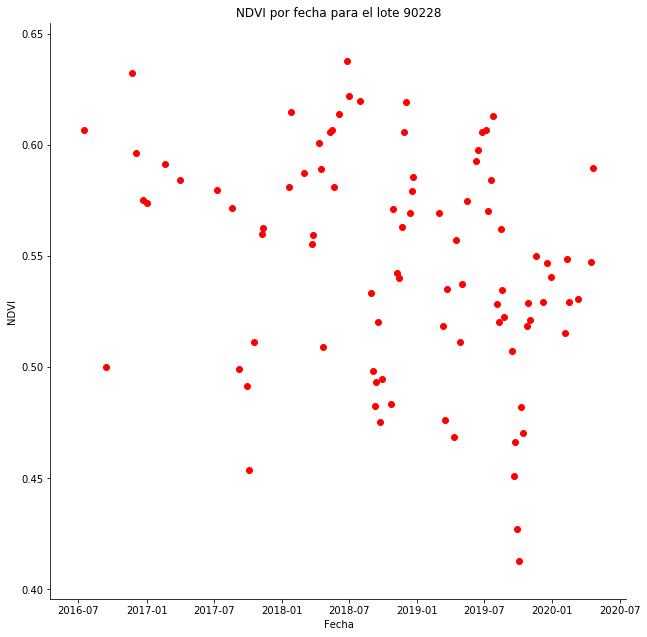

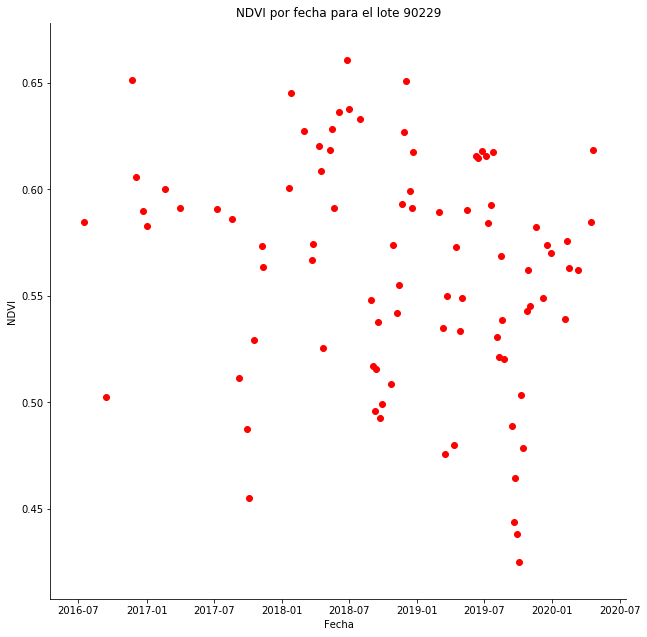

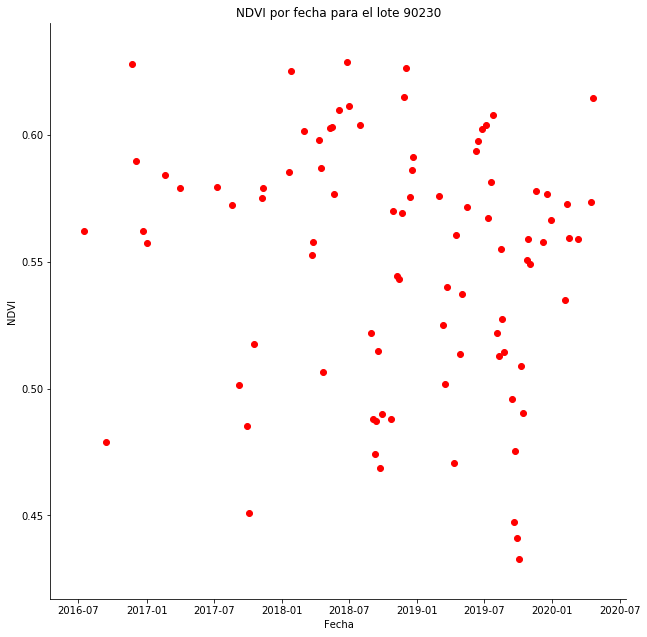

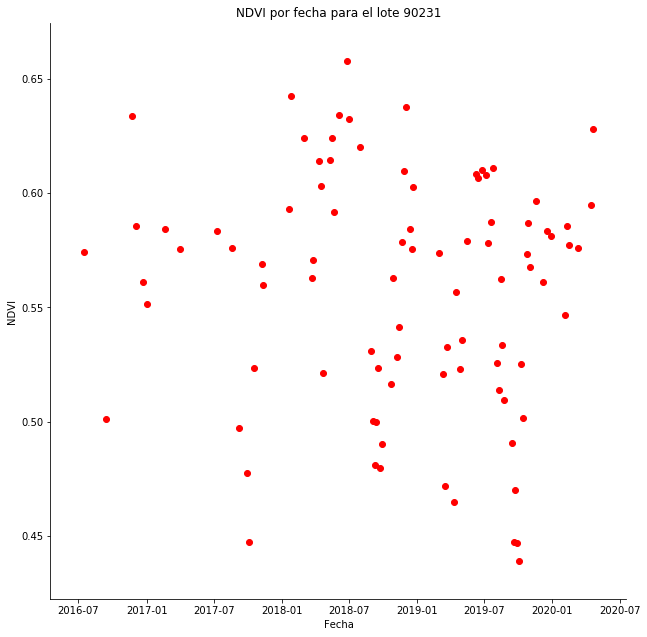

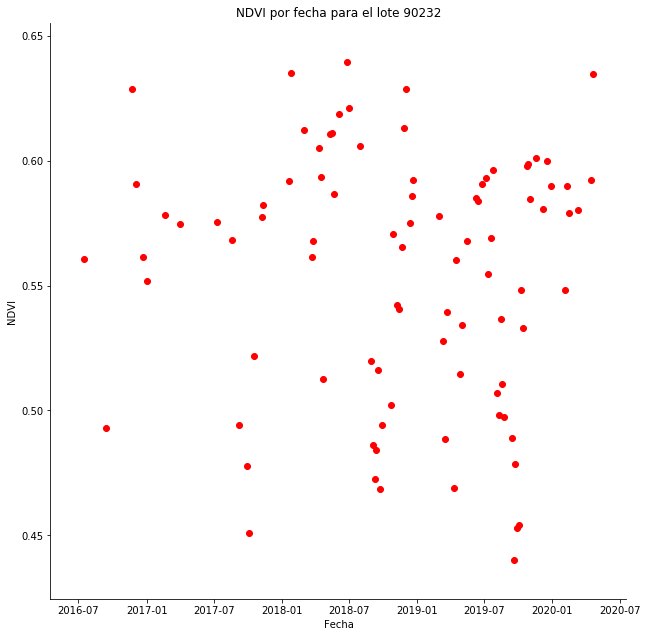

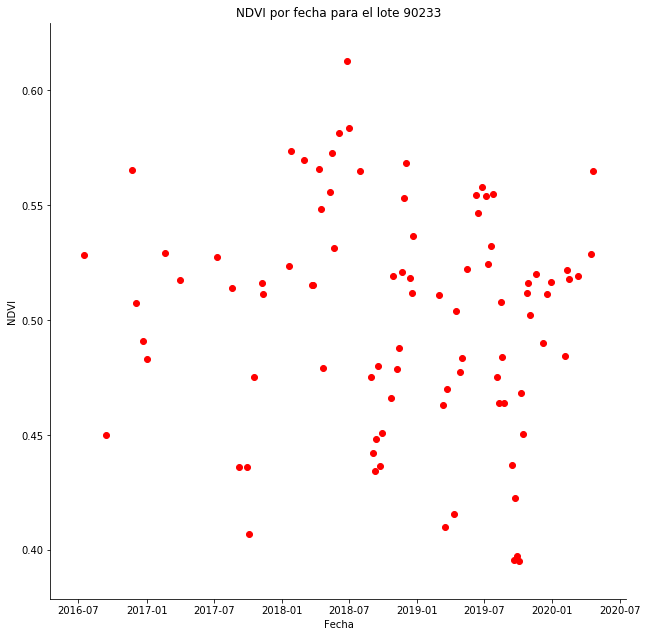

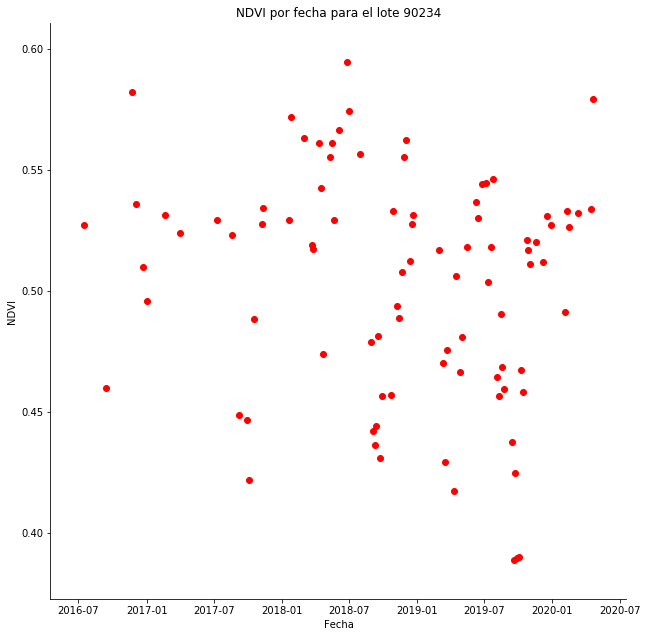

In [358]:
for lote_id in lotes_ndvi_altos:    
    fig=plt.figure(figsize=(8,8))
    ax=fig.add_axes([0,0,1,1])

    nvdi_values=df_nvdi[df_nvdi.id==lote_id].sort_values(by="fecha").ndvi_mean
    ndvi_fechas=df_nvdi[df_nvdi.id==lote_id].sort_values(by="fecha").fecha

    ax.scatter(ndvi_fechas, nvdi_values, color="red",label="lotes")
    ax.set_xlabel('Fecha')
    ax.set_ylabel('NDVI')
    ax.set_title('NDVI por fecha para el lote '+str(lote_id))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()




En el grupo 1 de lotes los valores del NDVI estan concentrados entre 0.4 y 0.6. No se observan tendecias claras salvo que fechas cercanas a Julio y Enero los lotes alcanzan su maximo de  NDVI y por el contrario en las fechas cercanas Octubre y Mayo los lotes alcanzan el NDVI mínimo. Esto se puede explicar por factores climáticos como la presencia de nubes o por cosecha.

### Lotes con menor NDVI promedio- Segundo Grupo

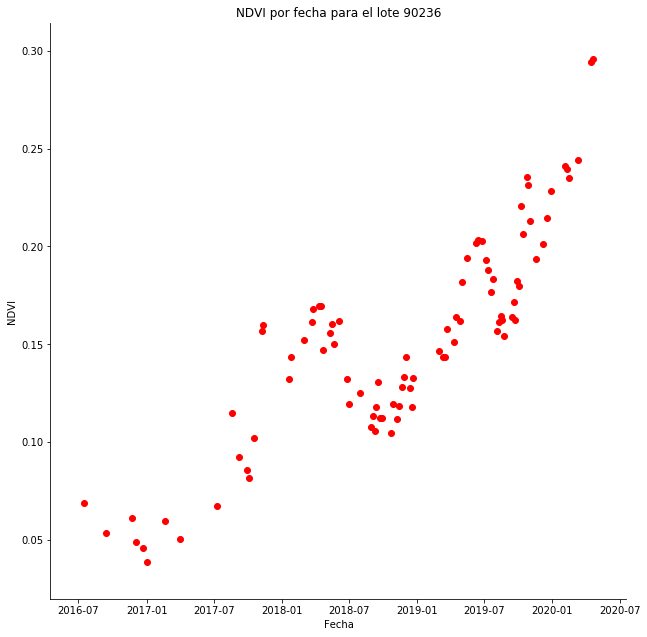

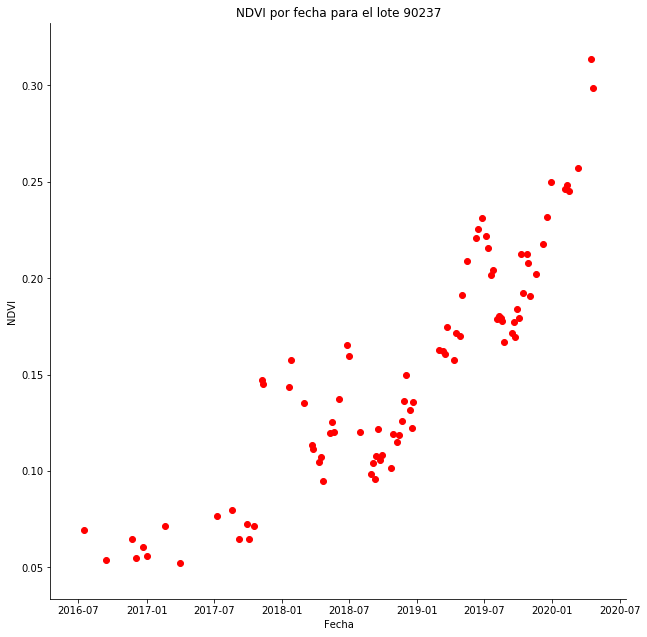

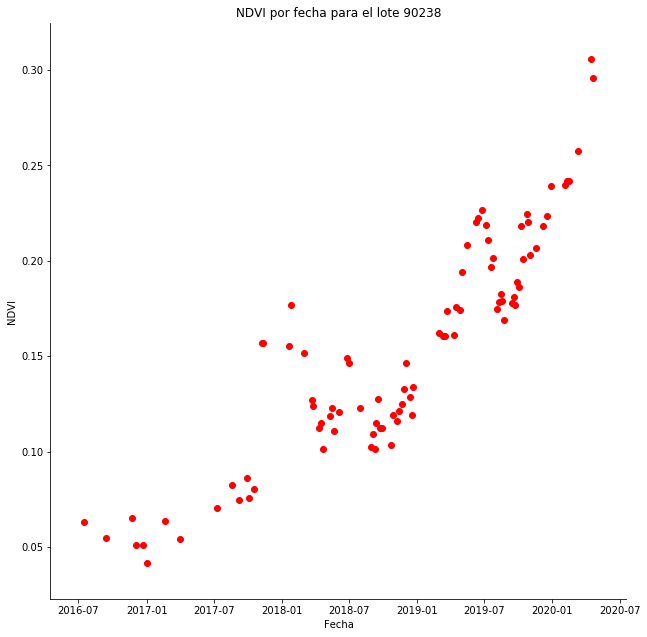

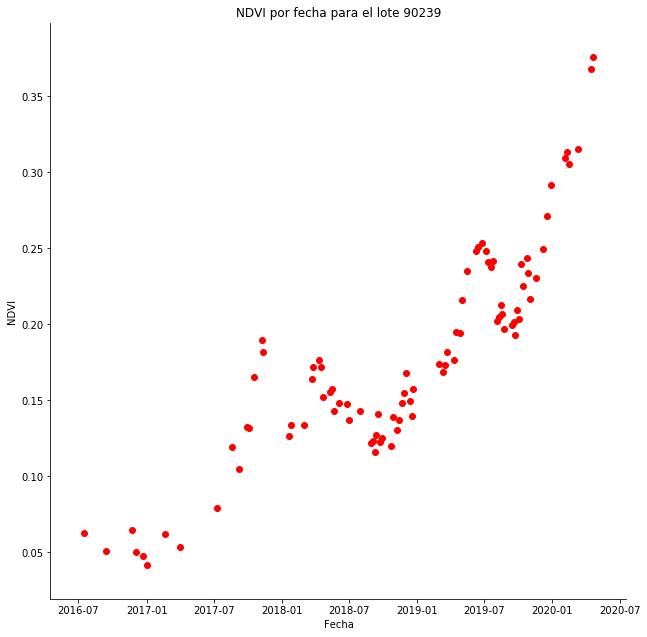

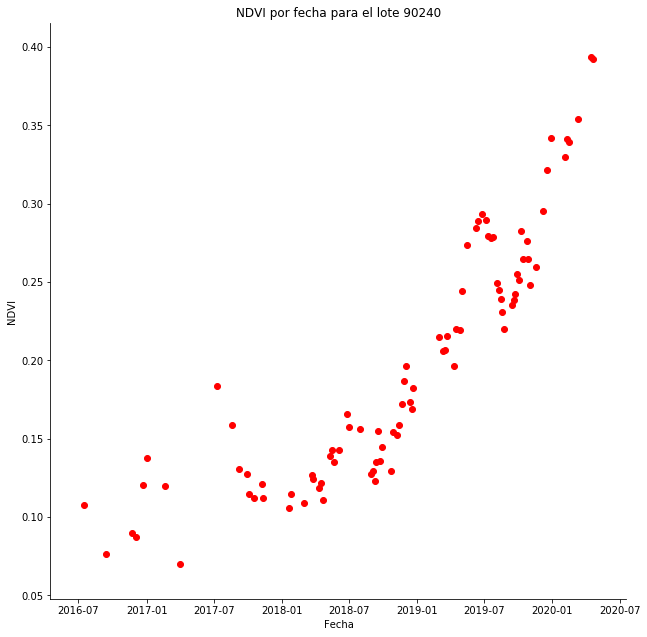

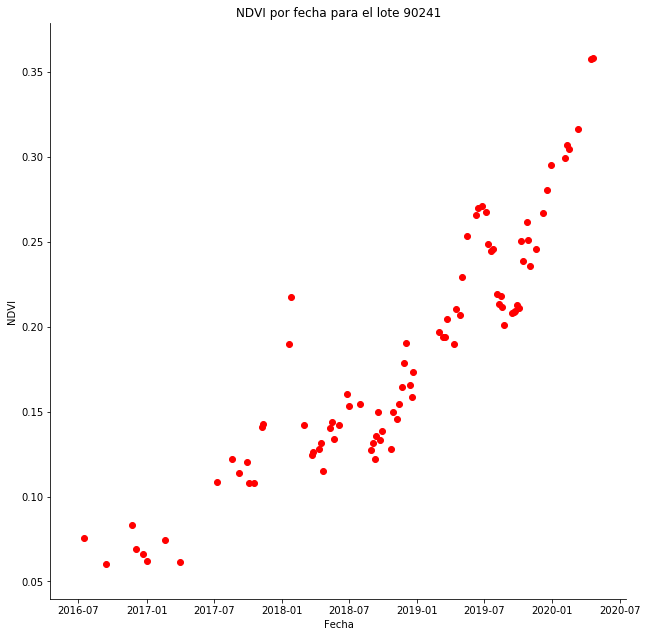

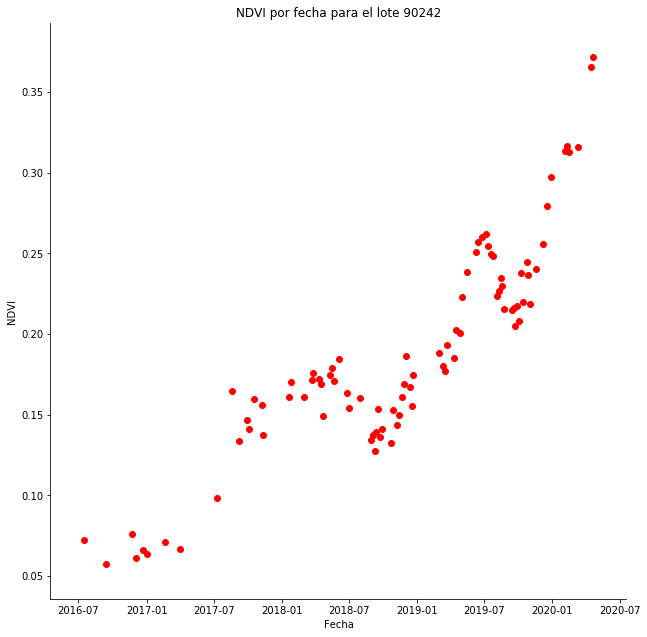

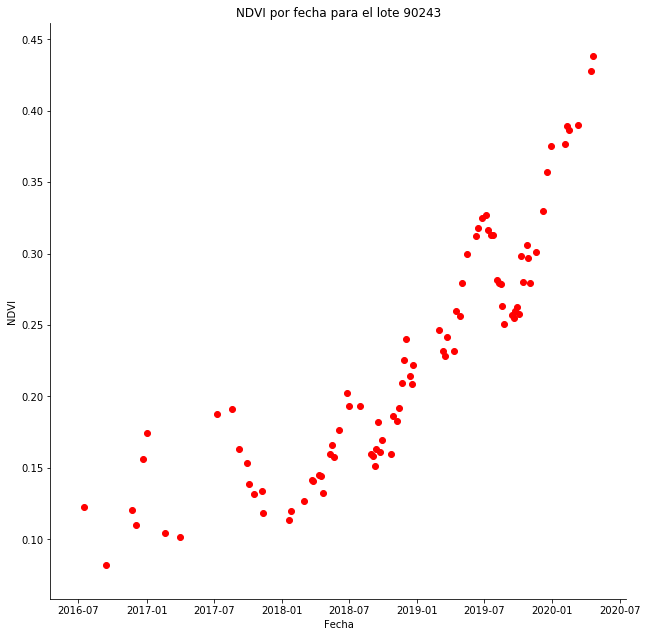

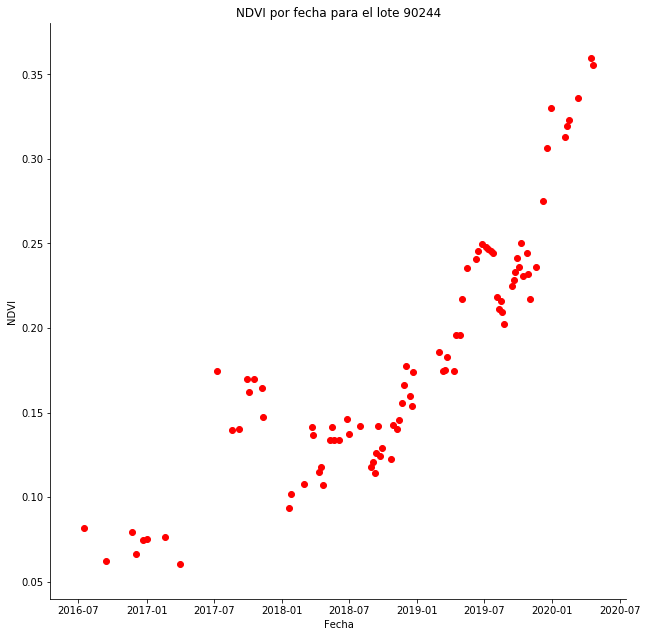

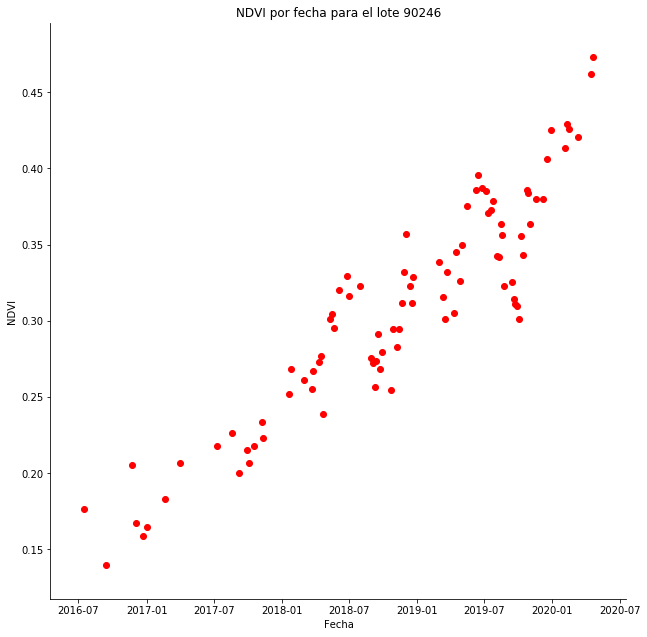

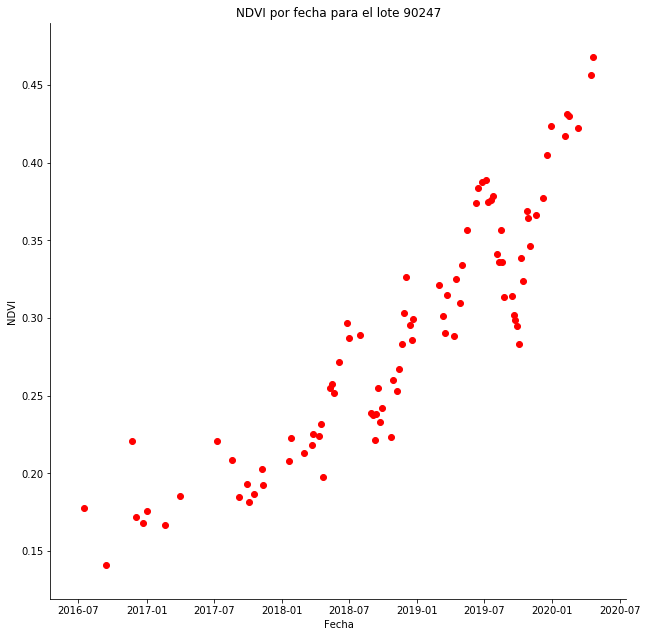

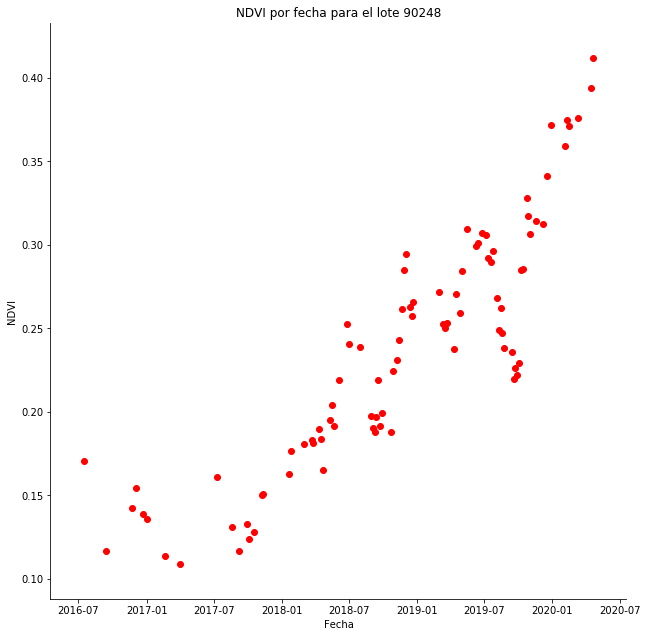

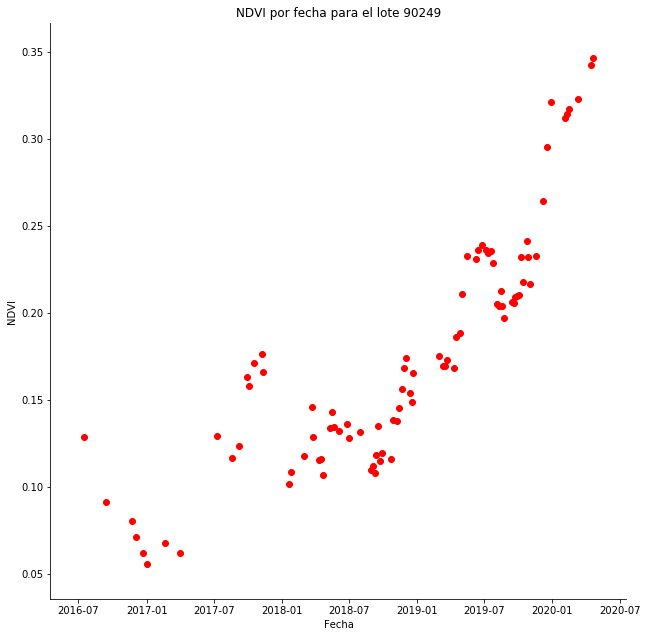

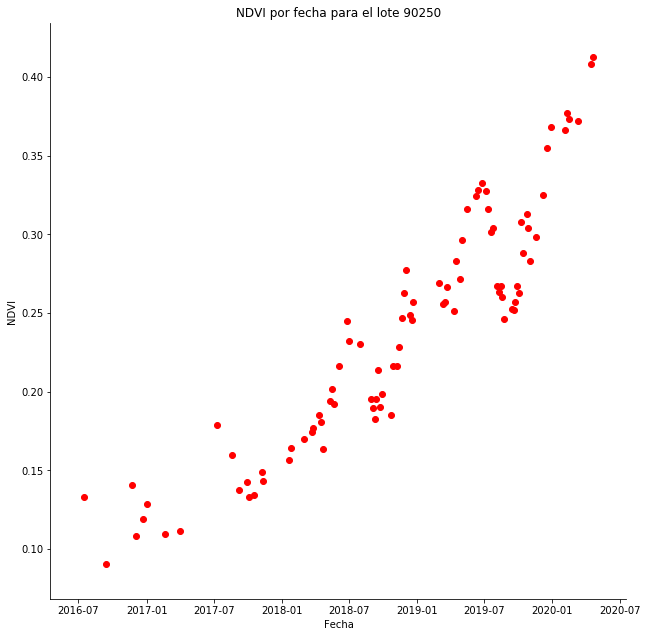

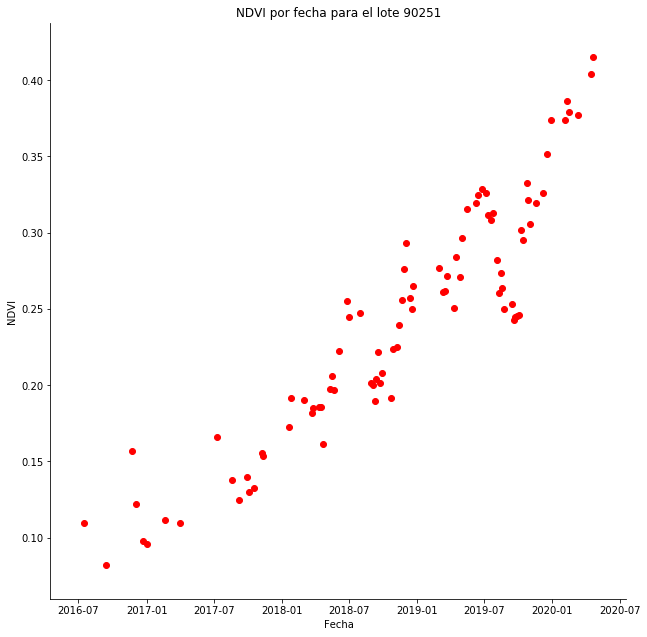

In [348]:
for lote_id in lotes_ndvi_bajos:    
    fig=plt.figure(figsize=(8,8))
    ax=fig.add_axes([0,0,1,1])

    nvdi_values=df_nvdi[df_nvdi.id==lote_id].sort_values(by="fecha").ndvi_mean
    ndvi_fechas=df_nvdi[df_nvdi.id==lote_id].sort_values(by="fecha").fecha

    ax.scatter(ndvi_fechas, nvdi_values, color="red",label="lotes")
    ax.set_xlabel('Fecha')
    ax.set_ylabel('NDVI')
    ax.set_title('NDVI por fecha para el lote '+str(lote_id))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

En el grupo 2 de lotes los valores del NDVI estan concentrados entre 0.1 y 0.4. Se observa una tendecias clara al alza del NDVI y la misma estacionalidad del grupo anterior marcada por las fechas cercanas a Julio y Enero con los máximos y las fechas cercanas a Octubre y Mayo con lotes alcanzan el NDVI mínimo. La tendencia al alza se puede explicar por que estos lotes estan siendo tratados para aumentar 

# Resumen de Insights

Identificamos la existencia de 2 tipos de lotes:



1. Los que tiene un NDVI promedio mayor que 4.5
2. Los que tiene un NDVI promedio menor que 3.5

Mirando la desviación estándar en tiempo de ambos grupos concluimos que los lotes del grupo 2 cambian en el tiempo mucho más que los del grupo 1.

Para el primer grupo, mirando las series de tiempo notamos que los valores del NDVI estan concentrados entre 0.4 y 0.6 . No se observan tendecias claras de subidas o bajadas. Se observa estacionalidad dado que en las fechas cercanas a Julio y Enero, los lotes alcanzan su maximo de  NDVI y por el contrario en fechas cercanas a Octubre y Mayo los lotes alcanzan el NDVI mínimo. Esto se puede explicar por factores climáticos como la presencia de nubes o por cosecha.

Para el segundo grupo los valores del NDVI estan concentrados entre 0.1 y 0.4. Se observa una tendecias clara al alza del NDVI y la misma estacionalidad del grupo anterior marcada por las fechas cercanas a Julio y Enero con los máximos y las fechas cercanas a Octubre y Mayo con lotes alcanzan el NDVI mínimo. La tendencia al alza se puede explicar por que estos lotes estan siendo tratados para aumentar el NDVI.

A continuación mostramos un ejemplo del último punto con el lote 9025 que esta en el grupo 2. La primera imagen corresponde al mes de mayo de este año y corresponde a un NDVI de 0.41

Imagen 1: Lote 9025 el 2020-04-20


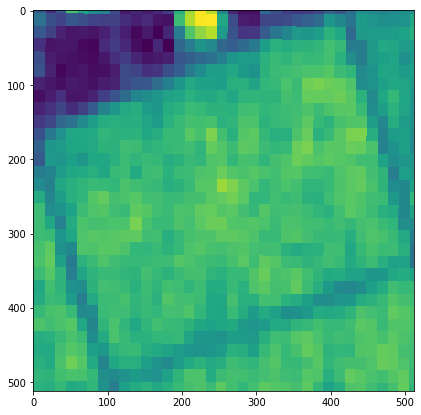

In [396]:
print("Imagen 1: Lote 9025 el 2020-04-20")
plot_image(df_nvdi[df_nvdi.id==90250].ndvi.iloc[0], factor=1)


 La segunda imagen corresponde al mes de Julio del año 2016 y corresponde a un NDVI de 0.13.

Imagen 2: Lote 9025 el 2016-07-15


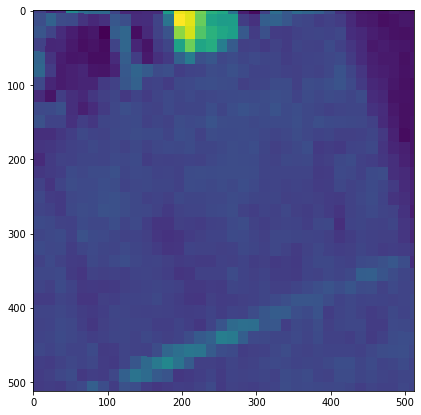

In [397]:
print("Imagen 2: Lote 9025 el 2016-07-15")
plot_image(df_nvdi[df_nvdi.id==90250].ndvi.iloc[-1], factor=1)